In [1]:
import importlib

from keras.layers import Input, Embedding, GRU, GRUCell, Bidirectional, TimeDistributed, Dense, Lambda
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
import keras.backend as K
from keras.utils import plot_model

import numpy as np
import random

from qgen.data import training_data, test_data, collapse_documents, expand_answers, _read_data

import qgen.utils as utils
from qgen.embedding import glove

import matplotlib.pyplot as plt

/Users/davidfoster/.virtualenvs/gdl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#### PARAMETERS ####

VOCAB_SIZE = glove.shape[0]
EMBEDDING_DIMENS = glove.shape[1]

GRU_UNITS = 100
MAX_DOC_SIZE = None
MAX_ANSWER_SIZE = None
MAX_Q_SIZE = None


In [3]:
#### TRAINING MODEL ####

document_tokens = Input(shape=(MAX_DOC_SIZE,), name="document_tokens")

embedding = Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIMENS, weights=[glove], mask_zero = True, name = 'embedding')
document_emb = embedding(document_tokens)

answer_outputs = Bidirectional(GRU(GRU_UNITS, return_sequences=True), name = 'answer_outputs')(document_emb)
answer_tags = Dense(2, activation = 'softmax', name = 'answer_tags')(answer_outputs)

encoder_input_mask = Input(shape=(MAX_ANSWER_SIZE, MAX_DOC_SIZE), name="encoder_input_mask")
encoder_inputs = Lambda(lambda x: K.batch_dot(x[0], x[1]), name="encoder_inputs")([encoder_input_mask, answer_outputs])
encoder_cell = GRU(2 * GRU_UNITS, name = 'encoder_cell')(encoder_inputs)

decoder_inputs = Input(shape=(MAX_Q_SIZE,), name="decoder_inputs")
decoder_emb = embedding(decoder_inputs)
decoder_emb.trainable = False
decoder_cell = GRU(2 * GRU_UNITS, return_sequences = True, name = 'decoder_cell')
decoder_states = decoder_cell(decoder_emb, initial_state = [encoder_cell])

decoder_projection = Dense(VOCAB_SIZE, name = 'decoder_projection', activation = 'softmax', use_bias = False)
decoder_outputs = decoder_projection(decoder_states)

total_model = Model([document_tokens, decoder_inputs, encoder_input_mask], [answer_tags, decoder_outputs])
plot_model(total_model, to_file='model.png',show_shapes=True)

In [4]:
#### INFERENCE MODEL ####

decoder_inputs_dynamic = Input(shape=(1,), name="decoder_inputs_dynamic")
decoder_emb_dynamic = embedding(decoder_inputs_dynamic)
decoder_init_state_dynamic = Input(shape=(2 * GRU_UNITS,), name = 'decoder_init_state_dynamic') #the embedding of the previous word
decoder_states_dynamic = decoder_cell(decoder_emb_dynamic, initial_state = [decoder_init_state_dynamic])
decoder_outputs_dynamic = decoder_projection(decoder_states_dynamic)

answer_model = Model(document_tokens, [answer_tags])
decoder_initial_state_model = Model([document_tokens, encoder_input_mask], [encoder_cell])
question_model = Model([decoder_inputs_dynamic, decoder_init_state_dynamic], [decoder_outputs_dynamic, decoder_states_dynamic])



In [5]:
### LOAD OLD MODELS ####

model_num = 6

total_model.load_weights('./saved_models/keras_{}.h5'.format(model_num), by_name = True)
question_model.load_weights('./saved_models/keras_{}.h5'.format(model_num), by_name = True)
answer_model.load_weights('./saved_models/keras_{}.h5'.format(model_num), by_name = True)
decoder_initial_state_model.load_weights('./saved_models/keras_{}.h5'.format(model_num), by_name = True)

In [6]:
#### LOAD DATA ####

test_data_gen = test_data()


In [7]:
#### GET TEST BATCH

batch = next(test_data_gen)
batch = collapse_documents(batch)

Predicted answer probabilities


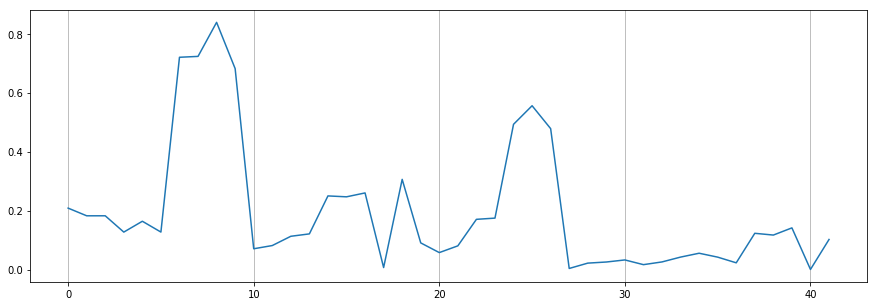

0 the 0.21
1 winning 0.18
2 goal 0.18
3 was 0.13
4 scored 0.16
5 by 0.13
6 23-year-old 0.72
7 striker 0.72
8 joe 0.84
9 bloggs 0.68
10 during 0.07
11 the 0.08
12 match 0.11
13 between 0.12
14 arsenal 0.25
15 and 0.25
16 barcelona 0.26
17 . 0.01
18 arsenal 0.31
19 recently 0.09
20 signed 0.06
21 the 0.08
22 striker 0.17
23 for 0.17
24 50 0.49
25 million 0.56
26 pounds 0.48
27 . 0.0
28 the 0.02
29 next 0.03
30 match 0.03
31 is 0.02
32 in 0.03
33 two 0.04
34 weeks 0.06
35 time, 0.04
36 on 0.02
37 july 0.12
38 31st 0.12
39 2005 0.14
40 . 0.0
41  0.1

Chosen answer range 37 : 39
['july', '31st', '2005']

Predicted Question
<START> when did the <UNK> start ? <END>


In [28]:
from qgen.embedding import START_TOKEN, END_TOKEN, look_up_token

plt.figure(figsize=(15,5))
idx = 0

answer_preds = answer_model.predict(batch["document_tokens"])

print('Predicted answer probabilities')
ax = plt.gca()
ax.xaxis.grid(True)
plt.plot(answer_preds[idx, :, 1])
plt.show()

for i in range(len(batch['document_words'][idx])):
    print(i, batch['document_words'][idx][i], np.round(answer_preds[idx][i][1],2))

start_answer = 37
end_answer = 39

print('\nChosen answer range', start_answer, ":", end_answer)
print(batch['document_words'][idx][start_answer:(end_answer+1)])

answers = [[0] * len(answer_preds[idx])]
for i in range(start_answer, end_answer + 1):
    answers[0][i] = 1
    
answer_batch = expand_answers(batch, answers)

next_decoder_init_state = decoder_initial_state_model.predict([answer_batch['document_tokens'][[idx]], answer_batch['answer_masks'][[idx]]])

word_tokens = [START_TOKEN]
questions = [look_up_token(START_TOKEN)]

ended = False

while not ended:

        word_preds, next_decoder_init_state = question_model.predict([word_tokens, next_decoder_init_state])

        next_decoder_init_state = np.squeeze(next_decoder_init_state, axis = 1)
        word_tokens = np.argmax(word_preds, 2)[0]

        questions.append(look_up_token(word_tokens[0]))

        if word_tokens[0] == END_TOKEN:
                ended = True

questions = ' '.join(questions)

print('\nPredicted Question')
print(questions)



In [29]:
test_data_gen = test_data()
batch = next(test_data_gen)
answer_preds = answer_model.predict(batch["document_tokens"])

idx = 0
start_answer = 37
end_answer = 39

answers = [[0] * len(answer_preds[idx])]
for i in range(start_answer, end_answer + 1):
    answers[idx][i] = 1

answer_batch = expand_answers(batch, answers)

next_decoder_init_state = decoder_initial_state_model.predict([answer_batch['document_tokens'][[idx]], answer_batch['answer_masks'][[idx]]])

word_tokens = [START_TOKEN]
questions = [look_up_token(START_TOKEN)]

ended = False

while not ended:

    word_preds, next_decoder_init_state = question_model.predict([word_tokens, next_decoder_init_state])

    next_decoder_init_state = np.squeeze(next_decoder_init_state, axis = 1)
    word_tokens = np.argmax(word_preds, 2)[0]

    questions.append(look_up_token(word_tokens[0]))

    if word_tokens[0] == END_TOKEN:
        ended = True

questions = ' '.join(questions)



In [30]:
questions

'<START> when did the <UNK> start ? <END>'